# K-Nearest Neighbours Classifier from Scratch
***
## Table of Contents
1. Load Data
2. Distance Metrics
3. Train Test Split
4. KNN Classifier
5. Calculating Accuracy
6. KNN Classifier with Objective-Oriented Design (OOD)
7. Predictions and Visualisation
8. Compare with Scikit-Learn
***

K-Nearest Neighbours (KNN) algorithm is a non-parametric supervised machine learning technique used for classification and regression. KNN predicts the class or value of a data point by calculating and analysing the distance from the data point to the $k$ closest neighbouring points in the training data. The algorithm uses a distance metric such as Euclidean, Manhattan, Chebyshev or Minkowski to identify the $k$ nearest neighbours and determines the predicted label or value based on a **majority vote** (for classification) or **averaging** (for regression).

In [369]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Data
Retrieved from [Kaggle - Iris Flower Dataset](https://www.kaggle.com/datasets/sims22/irisflowerdatasets)

In [370]:
df = pd.read_csv('iris.csv')
df.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


This dataset contains 4 features: **sepal_length**, **selap_width**, **petal_length** and **petal_width**, with 1 label representing the **species** of the Iris flower. The features describes the physical properties of sepals and petals which provide valuable information for classification. To better understand the relationships and distinctions amongst the species, let's visualise the dataset based on two primary characteristics: **sepal** and **petal**. 

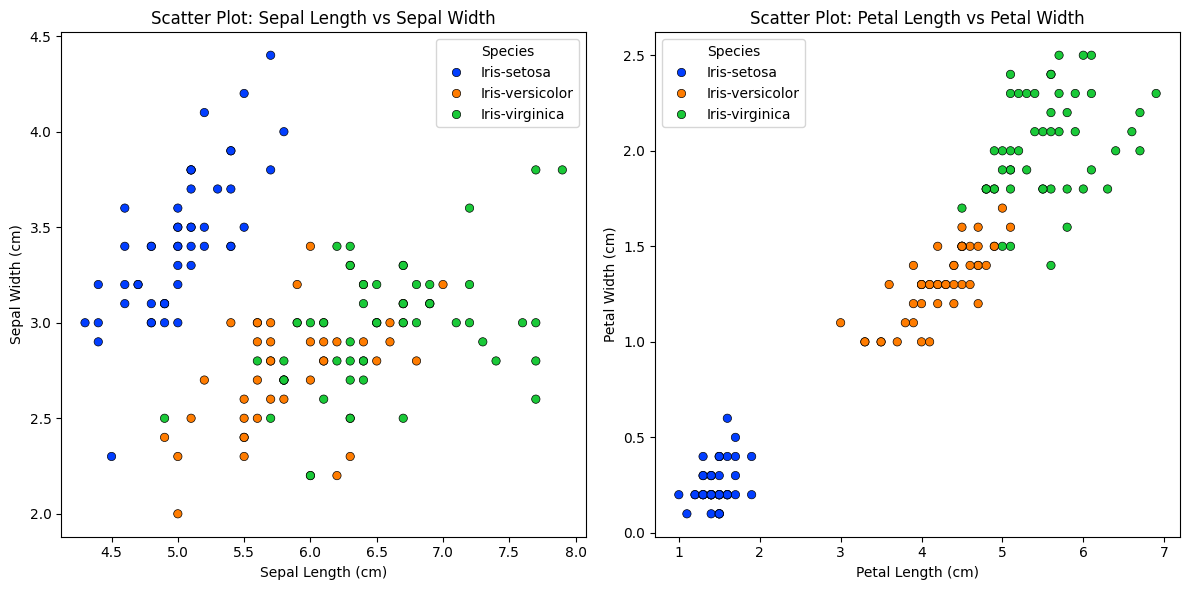

In [371]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

for i, feature in enumerate(['sepal', 'petal']):
    sns.scatterplot(ax=axes[i], data=df, x=f'{feature}_length', y=f'{feature}_width',
                    hue='species', palette='bright', edgecolor="black")
    axes[i].set_title(
        f'Scatter Plot: {str.title(feature)} Length vs {str.title(feature)} Width')
    axes[i].set_xlabel(f'{str.title(feature)} Length (cm)')
    axes[i].set_ylabel(f'{str.title(feature)} Width (cm)')
    axes[i].legend(title="Species")
plt.tight_layout()
plt.show()

By exploring the dataset, it becomes evident that sepal measurements are likely to overlap characteristics across different species. In contrast, petal measurements give much clear distinctions, making the features more suitable for accurate classification.

## 2. Distance Metrics 

### Euclidean Distance
Euclidean distance is the most widely used distance metric in KNN algorithms, which measures the shortest distance between two points as a straight line in multi-dimensional space.

\begin{align*}
\sqrt{\sum_{i=1}^{n} (a_i - b_i)^2}
\end{align*}


In [372]:
# Calculate Eucliean Distance
def calculate_euclidean(a: float, b: float) -> float:
    return np.sqrt(np.sum((a - b) ** 2))

### Manhattan Distance
Manhattan distance, also called Taxicab distance or City Block distance, calculates the distance between two points by summing the absolute differences of their coordinates. Manhattan distance follows a grid-like path where movement is restricted to horizontal and vertical directions only.

\begin{align*}
\sum_{i=1}^{n} |a_i - b_i|
\end{align*}

In [373]:
# Calculate Manhattan Distance
def calculate_manhattan(a: float, b: float) -> float:
    return np.sum(np.abs((a - b)))

### Chebyshev Distance
Chebyshev distance calculates the maximum absolute difference along any dimension, which is useful when the maximum difference is required for a model.

\begin{align*}
max_{i} |a_i - b_i|
\end{align*}

In [374]:
# Calculate Chebyshev Distance
def calculate_chebyshev(a: float, b: float) -> float:
    return np.max(np.abs((a - b)))


### Minkowski Distance
Minkowski distance is the generalised form of both Euclidean and Manhattan distances. When taking $p = 2$, it becomes the Euclidean distance, measuring straight-line distances. With $p=1$, it reduces to the Manhattan distance following a grid-based paths. As $p$ approaches infinity, it becomes the Chebyshev distance.


\begin{align*}
(\sum_{i=1}^{n} |a_i - b_i|^p)^{\frac{1}{p}}
\end{align*}

In [375]:
# Calculate Minkowski Distance
def calculate_minkowski(a: float, b: float, p: int) -> float:
    return np.sum(np.abs(a - b) ** p) ** (1 / p)

## 3. Train Test Split
Train test split is a fundamental model validation technique in machine learning. It divides a dataset into two separate portions: a **training set** used to train a model, and a **testing set** used to evaluate how well the model can perform on unseen data. 

The typical split ratio is 80% for training and 20% for testing, though this can vary (70/30 or 90/10 are also common). The key principle is that the test set must remain completely separated during model training process, and should never be used to make decisions about the model or tune parameters. 

The split is usually done randomly to ensure both sets are representative of the overall dataset, and many libraries (such as scikit-learn) provide build-in functions that handle this process automatically while maintaining proper randomisation.

In [376]:
def train_test_split(X: np.ndarray, y: np.ndarray, test_size: float = 0.2,
                     random_state: int = None) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split arrays or matrices into random train and test subsets.

    Args:
        X (np.ndarray): Input features, a 2D array with rows (samples) and columns (features).
        y (np.ndarray): Target values/labels, a 1D array with rows (samples).
        test_size (float): Proportion of the dataset to include in the test split. Must be between 0.0 and 1.0. default = 0.2
        random_state (int): Seed for the random number generator to ensure reproducible results. default = None

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        A tuple containing:
            - X_train (np.ndarray): Training set features.
            - X_test (np.ndarray): Testing set features.
            - y_train (np.ndarray): Training set target values.
            - y_test (np.ndarray): Testing set target values.
    """
    # Set a random seed if it exists
    if random_state:
        np.random.seed(random_state)

    # Create a list of numbers from 0 to len(X)
    indices = np.arange(len(X))

    # Shuffle the indices
    np.random.shuffle(indices)

    # Define the size of our test data from len(X)
    test_size = int(test_size * len(X))

    # Generate indices for test and train data
    test_indices: list[int] = indices[:test_size]
    train_indices: list[int] = indices[test_size:]

    # Return: X_train, X_test, y_train, y_test
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

## 4. KNN Classifier

This function implements the core KNN classification algorithm by finding the k closest training samples to each test sample and predicting the class based on majority voting among these neighbors. The classification follows these steps for each test point:
1. Calculate Euclidean distance to all training points
2. Sort distances and select k smallest (nearest neighbors)
3. Extract labels of these k neighbors
4. Find the most frequent label (majority vote)
5. Assign this label as the prediction

In [377]:
def knn_classifier_func(X_train: np.ndarray, y_train: np.ndarray,
                        X_test: np.ndarray, k: int = 3) -> np.ndarray[str]:
    """
    Classify test samples using the k-Nearest Neighbors algorithm.

    Args:
        X_train (np.ndarray): Training features, a 2D array with rows (samples) and columns (features).
        y_train (np.ndarray): Training labels, a 1D array of labels corresponding to X_train.
        X_test (np.ndarray): Test features, a 2D array with rows (samples) and columns (features).
        k (int): The number of nearest neighbours to consider for classification. default = 3.
    Returns:
       prediction_list (np.ndarray[str]): List of predicted class labels for each test sample.
   """

    prediction_list: np.ndarray[str] = []

    # For each point in X_test, calculate the distance to all the points in X_train.
    for x_test in X_test:
        distance_list: np.ndarray[float] = []
        for x_train in X_train:
            # Add the calculated distance to distance_list.
            distance_list.append(calculate_euclidean(
                x_test, x_train))

        # Select k neighbours based on the distance in descending order.
        k_neighbours: np.ndarray[int] = np.argsort(distance_list)[:k]

        # Majority vote amongst k neighbours to determine a label of each point.
        k_neighbour_labels: np.ndarray[str] = [
            y_train[i] for i in k_neighbours]
        most_common: str = max(
            k_neighbour_labels, key=k_neighbour_labels.count)

        # Add the most common label to prediction_list as a prediction.
        prediction_list.append(most_common)
    return prediction_list

## 5. Evaluation Metrics
### Binary Confusion Matrix
In a confusion matrix, the terms True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) describe the classification performance for binary classification. 

|                     | Predicted Negative  | Predicted Positive  |
| ------------------- | ------------------- | ------------------- |
| **Actual Negative** | True Negative (TN)  | False Positive (FP) |
| **Actual Positive** | False Negative (FN) | True Positive (TP)  |


1. True Positive (TP): The number of instances correctly predicted as positive (e.g., a disease correctly identified).

2. True Negative (TN): The number of instances correctly predicted as negative (e.g., no disease correctly identified).

3. False Positive (FP): The number of instances incorrectly predicted as positive (e.g., predicting disease when there isn't any).

4. False Negative (FN): The number of instances incorrectly predicted as negative (e.g., missing a disease when it exists).

### Multi-Class Confusion Matrix
For multi-class classification, the concepts can be extended by treating one class as the "positive" class and all others as "negative" classes in a one-vs-all approach. Rows represent the actual classes (true labels), and columns represent the predicted classes. For a class $C$,
1. True Positive (TP): The count in the diagonal cell corresponding to class $C$ ($\text{matrix} [C][C]$).
2. False Positive (FP): The sum of the column for class $C$, excluding the diagonal ($\sum(\text{matrix} [:, C]) - \text{matrix} [C][C]$).
3. False Negative (FN): The sum of the row for class $C$, excluding the diagonal ($\sum(\text{matrix} [C, :]) - \text{matrix} [C][C]$).
4. True Negative (TN): All other cells not in the row or column for class $C$ ($\text{total} - (FP + FN + TP)$).

|                  | Predicted Class 0 | Predicted Class 1 | Predicted Class 2 |
| ---------------- | ----------------- | ----------------- | ----------------- |
| **True Class 0** | 5                 | 2                 | 0                 |
| **True Class 1** | 1                 | 6                 | 1                 |
| **True Class 2** | 0                 | 2                 | 7                 |


For Class 0:
- TP = 5 (diagonal element for Class 0)
- FP = 1 (sum of column 0 minus TP: 1 + 0)
- FN = 2 (sum of row 0 minus TP: 2 + 0)
- TN = 6 + 1 + 2 + 7 = 16 (all other cells not in row 0 or column 0)

For Class 1:
- TP = 6 (diagonal element for Class 1)
- FP = 4 (sum of column 1 minus TP: 2 + 2)
- FN = 2 (sum of row 1 minus TP: 1 + 1)
- TN = 5 + 0 + 0 + 7 = 12 (all other cells not in row 1 or column 1)

In [378]:
def confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, class_names: list = None) -> tuple[np.ndarray, list]:
    """
    Calculate the confusion matrix.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        class_names (list, optional): List of class names. Defaults to None.

    Returns:
        tuple: 
        - np.ndarray: Confusion matrix.
        - list: List of class names.
    """
    # Encode labels as integers
    unique_classes = np.unique(np.concatenate((y_true, y_pred)))
    if class_names is None:
        class_names = [str(cls) for cls in unique_classes]
    class_to_index = {cls: i for i, cls in enumerate(unique_classes)}

    n_classes = len(unique_classes)
    matrix = np.zeros((n_classes, n_classes), dtype=int)

    for true, pred in zip(y_true, y_pred):
        true_idx = class_to_index[true]
        pred_idx = class_to_index[pred]
        matrix[true_idx][pred_idx] += 1

    return matrix, class_names

### Accuracy
Accuracy is the most common evaluation metric for classification problems, representing the percentage of correct predictions out of total predictions. It provides a simple measure of how often the classifier makes correct predictions across all classes.

\begin{align*}
\text{Accuracy} = \dfrac{\text{True Positives (TP)} + \text{True Negatives (TN)}}{\text{Total Samples}}
\end{align*}

In [379]:
def calculate_accuracy(y_true: np.ndarray,
                       y_pred: np.ndarray) -> float:
    """
    Calculate the accuracy of predictions by comparing true and predicted labels.

    Args:
        y_true (np.ndarray): Ground truth target values. Contains the actual class labels for each sample.
        y_pred (np.ndarray): Estimated target as returned by a classifier. Contains the predicted class labels for each sample.
    Returns:
        float: Classification accuracy as a percentage (0.0 to 100.0).
    """
    return np.mean(y_true == y_pred)

### Precision
Precision measures the proportion of true positive predictions out of all positive predictions made by the classifier.

\begin{align*}
\text{Precision} = \dfrac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
\end{align*}

In [380]:
def precision(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """
    Calculate precision for each class.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.

    Returns:
        np.ndarray: Precision values for each class.
    """
    cm, _ = confusion_matrix(y_true, y_pred)
    return np.diag(cm) / (np.sum(cm, axis=0) + 1e-7)

### Recall
Recall measures the proportion of true positive predications out of all actual positive cases.

\begin{align*}
\text{Recall} = \dfrac{\text{True Positives (TP)} }{\text{True Positives (TP)} + \text{False Negatives (FN)}}
\end{align*}

In [381]:
def recall(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """
    Calculate recall for each class.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.

    Returns:
        np.ndarray: Recall values for each class.
    """
    cm, _ = confusion_matrix(y_true, y_pred)
    return np.diag(cm) / (np.sum(cm, axis=1) + 1e-7)

### F1-Score
The F1-Score is the harmonic mean of precision and recall.

\begin{align*}
\text{F1-Score} = 2 \times \dfrac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\end{align*}

In [382]:
def f1_score(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """
    Calculate F1-score for each class.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.

    Returns:
        np.ndarray: F1-scores for each class.
    """
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + 1e-7)

In [383]:
def evaluate(y_true: np.ndarray, y_pred: np.ndarray, class_names: list = None) -> None:
    """
    Print evaluation metrics including precision, recall, and F1-score for each class.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        class_names (list, optional): List of class names. Defaults to None.
    """
    cm, class_names = confusion_matrix(y_true, y_pred, class_names)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    # print("Class\tPrecision\tRecall\tF1-Score")
    # for i, class_name in enumerate(class_names):
    #     print(f"{class_name}\t{prec[i]:.4f}\t\t{rec[i]:.4f}\t{f1[i]:.4f}")
    return np.mean(prec), np.mean(rec), np.mean(f1), cm

Let's set the value of $k$ to 7, meaning the model will analyse the 7 closest data points to each test sample when making predictions. We'll evaluate the KNN classifier's performance using two different pairs of features from the iris dataset: sepal length with sepal width, and petal length with petal width.

In [384]:
k = 7
for feature in ['sepal', 'petal']:
    X: np.ndarray[float] = df[[f'{feature}_length', f'{feature}_width']].values
    y: np.ndarray[str] = df['species'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    predictions: np.ndarray[str] = knn_classifier_func(
        X_train, y_train, X_test, k)
    accuracy: float = calculate_accuracy(y_test, predictions)
    prec, rec, f1, cm = evaluate(y_test, predictions)
    print(f"Metrics for '{feature}' features with k = {k}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print('--------------------')

Metrics for 'sepal' features with k = 7:
Accuracy: 0.7667
Precision: 0.7667
Recall: 0.7677
F1-Score: 0.7661
Confusion Matrix:
[[10  0  0]
 [ 0  6  3]
 [ 0  4  7]]
--------------------
Metrics for 'petal' features with k = 7:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
--------------------


## 6. KNN Classifier with Objective-Oriented Design (OOD)
The Objective-Oriented Design (OOD) approach transforms the KNN model above from a collection of functions into a cohesive, professional-grade machine learning tool that's easier to use, extend, and maintain. It follows established design patterns and provides a familiar interface that integrates well with existing ML workflows. Let's rewrite the previous code using `class` to make it objective-oriented.

In [385]:
class CustomKNNClassifier:
    """
    A simple K-Nearest Neighbours (KNN) classifier.
    """

    def __init__(self, k: int = 3) -> None:
        """
        Initialise the model with k, the number of neighbours.

        Args: 
            k (int): The number of nearest neighbours to consider for classification. default = 3.
        """
        self.k = k

    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """
        Fit the training data.

        Args:
            X_train (np.ndarray): Training features, a 2D array with rows (samples) and columns (features).
            y_train (np.ndarray): Training labels, a 1D array of labels corresponding to X_train.
        """
        self.X_train = X_train
        self.y_train = y_train

    def calculate_distance(self, x1: float, x2: float) -> float:
        """
        Calculate the Euclidean distance between two points.

        Args:
            x1 (float): First point.
            x2 (float): Second point.

        Returns:
            float: The Euclidean distance between x1 and x2.
        """
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Predict the labels for X_test.

        Args:
            X_test (np.ndarray): Test features, a 2D array with rows (samples) and columns (features).

        Returns:
            np.ndarray: Predicted labels for each test sample.
        """
        return np.array([self._predict(x_test)[0] for x_test in X_test])

    def _predict(self, x_test: np.ndarray) -> tuple[str, np.ndarray,  np.ndarray]:
        """
        Predict the label for a single test sample and provide additional detals.

        Args:
            x_test (np.ndarray): A single test sample.

        Returns:
            tuple: A tuple containing:
            - str: The most common label among the k nearest neighbours.
            - np.ndarray: Indices of the k nearest neighbours.
            - np.ndarray: Labels of the k nearest neighbours.
        """
        distance_list: np.ndarray[float] = [calculate_euclidean(
            x_test, x_train) for x_train in self.X_train]

        k_neighbours: np.ndarray[int] = np.argsort(distance_list)[:self.k]

        k_neighbours_labels: np.ndarray[int] | np.ndarray[str] = [
            self.y_train[i] for i in k_neighbours]
        most_common: str = max(k_neighbours_labels,
                               key=k_neighbours_labels.count)
        return most_common, k_neighbours, k_neighbours_labels

In [386]:
for feature in ['sepal', 'petal']:

    # Separate features and labels
    X = df[[f'{feature}_length', f'{feature}_width']].values
    y = df['species'].values

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Initialise and fit train data to KNN Classifier
    knn_classifier = CustomKNNClassifier(k=k)
    knn_classifier.fit(X_train, y_train)

    # Make predictions and calculate accuracy of the model
    predictions = knn_classifier.predict(X_test)
    accuracy = calculate_accuracy(y_test, predictions)
    # print(f"Accuracy for '{feature}' with k = {k}: {accuracy:.4f}")
    prec, rec, f1, cm = evaluate(y_test, predictions)
    print(f"Metrics for '{feature}' features with k = {k}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print('--------------------')

Metrics for 'sepal' features with k = 7:
Accuracy: 0.7667
Precision: 0.7667
Recall: 0.7677
F1-Score: 0.7661
Confusion Matrix:
[[10  0  0]
 [ 0  6  3]
 [ 0  4  7]]
--------------------
Metrics for 'petal' features with k = 7:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
--------------------


## 7. Predictions and Visualisation

Now, let's make predictions on arbitrary data points and visualise them. First, we'll create a function that allows us to visualise how KNN works in practice. This visualisation will help us understand the decision-making process of the KNN algorithm by showing how it identifies the nearest neighbours and make classifications based on the proximity of data points in the feature space. The red markers will clearly indicate our test points, making it easy to see which neighbouring points the algorithm considers when making its preditions.

In [387]:
def visualise_single_prediction(feature: str, nearest_points: np.ndarray, point: np.ndarray,
                                df: pd.DataFrame = df) -> None:
    """
    Visualise a single KNN prediction by plotting the test point and its k nearest neighbours.

    Args:
        feature (str): The feature name to be visualised.
        nearest_points (np.ndarray): An array of coordinates representing the k nearest neighbours of the test point.
        point (np.ndarray): An array of coordinates representing a sample point.
        df (pd.DataFrame): The dataframe containing features and labels. default = df

    Returns:
        None
    """

    # Initialise subplots (2 columns, 1 row)
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
    for i in range(2):
        # Scatter plot for data points and species
        sns.scatterplot(ax=axes[i], data=df, x=f'{feature}_length', y=f'{feature}_width',
                        hue='species', palette='bright', edgecolor="black")
        # Highlight the test point with a red marker
        sns.scatterplot(ax=axes[i], x=[point[0]], y=[
                        point[1]], color='red', edgecolor="black")
        # For figure 1 (left)
        if i == 0:
            # Annotate the test point
            axes[i].annotate(
                "Point",
                xy=(point[0]+0.01, point[1]),
                xytext=(point[0] + 0.2, point[1] + 0.2),
                arrowprops=dict(facecolor="black", arrowstyle="->", lw=3),
                fontsize=15,
                color="black",
            )
        # For figure 2 (right)
        else:
            # Connect test point with its nearest neighbours
            for neighbor in nearest_points:
                axes[i].plot([point[0], neighbor[0]], [point[1],
                                                       neighbor[1]], color='black', linestyle='--')
        axes[i].set_title(
            f'Scatter Plot: {str.title(feature)} Length vs {str.title(feature)} Width')
        axes[i].set_xlabel(f'{str.title(feature)} Length (cm)')
        axes[i].set_ylabel(f'{str.title(feature)} Width (cm)')
        axes[i].legend(title="Species")

    plt.tight_layout()
    plt.show()

We'll select one data point representing `sepal` measurements, and another one representing `petal` measurements, which will be marked in red on the graphs below.

In [388]:
from collections import Counter
one_point_sepal = np.array([5.0, 2.8])
one_point_petal = np.array([5.1, 1.1])

features_points: dict = {'sepal': one_point_sepal,
                         'petal': one_point_petal}

Prediction for point (sepal) [5.  2.8]: Iris-setosa
Counter({'Iris-setosa': 4, 'Iris-versicolor': 2, 'Iris-virginica': 1})


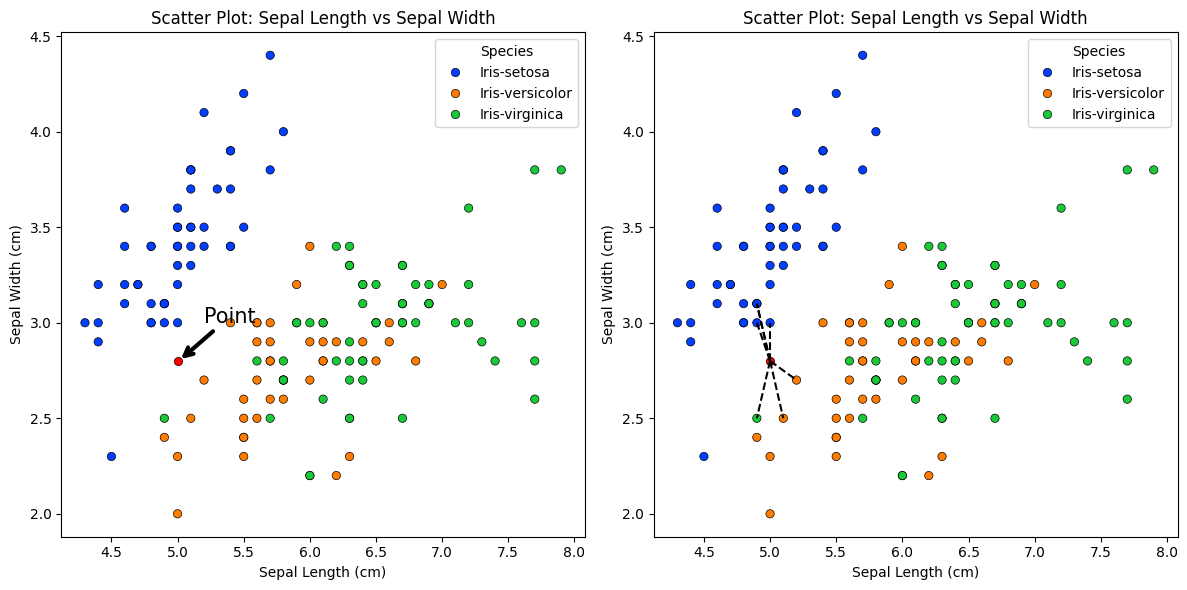

Prediction for point (petal) [5.1 1.1]: Iris-versicolor
Counter({'Iris-versicolor': 5, 'Iris-virginica': 2})


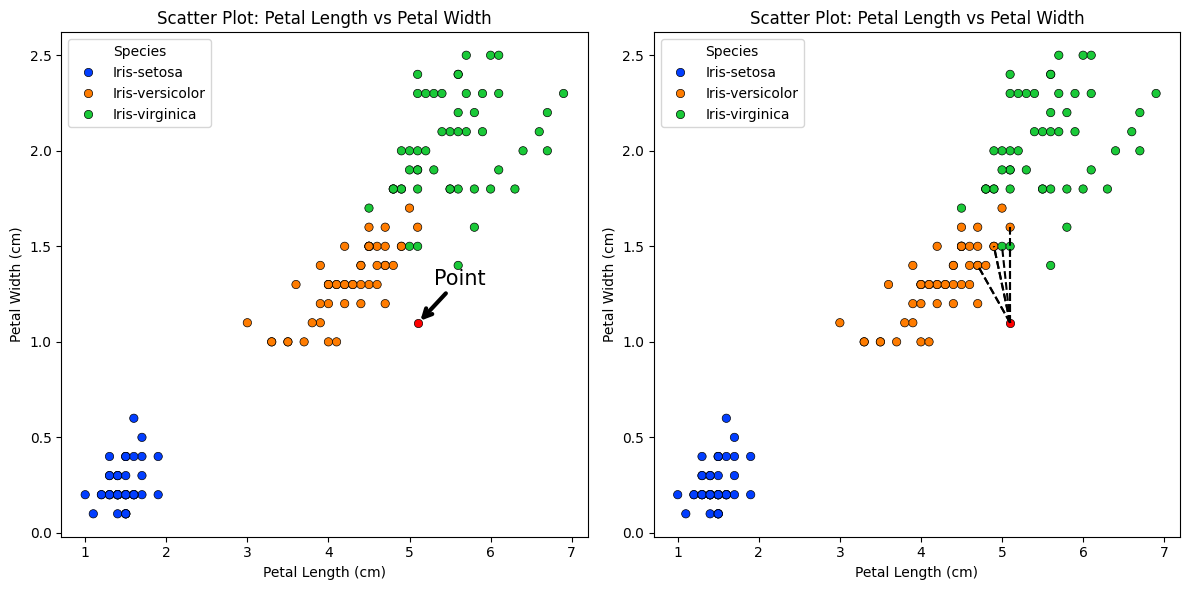

In [389]:
for feature, point in features_points.items():
    X = df[[f'{feature}_length', f'{feature}_width']].values
    y = df['species'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    knn_classifier = CustomKNNClassifier(k=k)
    knn_classifier.fit(X_train, y_train)
    prediction, k_neighbours, k_neighbours_labels = knn_classifier._predict(
        point)
    nearest_points = X_train[k_neighbours]
    print(f"Prediction for point ({feature}) {point}: {prediction}")
    print(Counter(k_neighbours_labels))
    visualise_single_prediction(feature, nearest_points, point)

In the first experiment analysing sepal measurements, the KNN classifier evaluated the $k=7$ nearest neighbours from the given data point. Amongst these neighbours, 4 were classified as `Iris-setosa`, 2 as `Iris-versicolor`, and 1 as `Iris-virginica`. Through majority voting, `Iris-setosa` was determined to be the predicted class for this data point. Similarly, in the second experiment examining petal measurements, 5 of the nearest neighbours were `Iris-versicolor` and 2 were `Iris-virginica`. Consequently, `Iris-versicolor` was selected as the predicted class for the second data point.

## 8. Compare with Scikit-Learn

In [390]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Define k value for KNN
k = 7

# Iterate over feature sets and calculate accuracy
for feature in ['sepal', 'petal']:
    # Separate features and labels
    X = df[[f'{feature}_length', f'{feature}_width']].values
    y = df['species'].values

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Initialize and fit the KNN Classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)

    # Make predictions
    predictions = knn_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    cm = confusion_matrix(y_test, predictions)

    print(f"Metrics for '{feature}' features with k = {k}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))
    print('--------------------')

Metrics for 'sepal' features with k = 7:
Accuracy: 0.7667
Precision: 0.7700
Recall: 0.7667
F1-Score: 0.7673
Confusion Matrix:
[[10  0  0]
 [ 0  6  3]
 [ 0  4  7]]

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.60      0.67      0.63         9
 Iris-virginica       0.70      0.64      0.67        11

       accuracy                           0.77        30
      macro avg       0.77      0.77      0.77        30
   weighted avg       0.77      0.77      0.77        30

--------------------
Metrics for 'petal' features with k = 7:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00     

We obtained very similar results as our custom KNN ! 